## Question:
Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

**Null Hypothesis**: H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game when a team is playing in front of their home crowd.

**Alternative Hypothesis**: H<sub>a</sub> = There is *always* a difference in the odds of winning a game when a team is playing in front of their home crowd.

In [28]:
import pandas as pd
import numpy as np
import psycopg2
from scipy import stats
import seaborn as sns

In [29]:
conn = psycopg2.connect('dbname=football_db')

In [30]:
cur = conn.cursor()

In [31]:
columns = ['id', 'home_goal', 'away_goal', 'result']

query = f"""
SELECT match_api_id, home_team_goal, away_team_goal, 
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
         ELSE 'NoWin' END as Result
FROM Match
"""

cur.execute(query)
data = cur.fetchall()

In [32]:
df = pd.DataFrame(data, columns=columns)

In [33]:
df.head()

,id,home_goal,away_goal,result
0,492473,1,1,NoWin
1,492474,0,0,NoWin
2,492475,0,3,NoWin
3,492476,5,0,Win
4,492477,1,3,NoWin


In [34]:
total_wins = len(df[df['result'] == 'Win'])
total_wins

11917

In [35]:
total_games = len(df['result'])
total_games

25979

In [36]:
# Population mean (μ)
mu = total_wins / total_games
mu

0.45871665576042187

In [37]:
sample_size = 2000
number_of_games = 2000
samples = np.zeros(sample_size)
for i in range(sample_size):
    games = df.iloc[np.random.randint(low=0, high=len(df), size=number_of_games), :]
    win_rate = len(games[games['result'] == 'Win']) / number_of_games
    samples[i] = win_rate


In [38]:
sample_mean = samples.mean()
sample_mean

0.45829600000000004

In [39]:
std = np.std(samples, ddof=1)
std

0.011196821799475265

In [40]:
t = (sample_mean - mu) / (std / np.sqrt(sample_size))
t

-1.6801461919741476

In [41]:
# Degrees of Freedom
df = sample_size - 1

In [42]:
t_crit = np.round(stats.t.ppf(1 - 0.05, df), 3)
t_crit

1.646

In [49]:
results = stats.ttest_1samp(a=samples, popmean=mu)
print(results)
print('\n')

if (results[0]>t_crit) and (results[1]<0.05):
    print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", np.round((results[1]), 4))
else:
    print ("Null hypothesis is Accepted")

Ttest_1sampResult(statistic=-1.6801461919741476, pvalue=0.09308512197631458)


Null hypothesis is Accepted


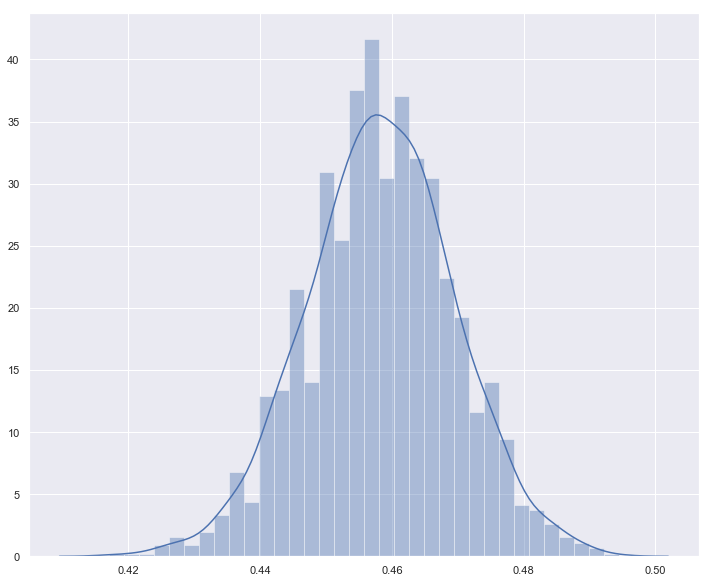

In [45]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(samples)

## Result:
While limiting alpha to 0.05, The P-value is > 0.05. This concludes that there is no statistical difference when a team wins in front of a home crowd or wins at away games.

In [18]:
columns = ['team_short_name', 'team_api_id', 'Category', 'Result', 'Count' ]

query = f"""
SELECT A.team_short_name as Team, B.* FROM
(SELECT T.team_api_id, 'Home' as Category,
CASE WHEN M1.home_team_goal - M1.away_team_goal > 0 THEN 'Win' ELSE 'No' END as Result,
COUNT(*) as Count
FROM Team T
JOIN Match M1 ON T.team_api_id = M1.home_team_api_id
GROUP BY T.team_api_id, Result
UNION SELECT T.team_api_id, 'Away' as Category,
CASE WHEN M1.home_team_goal - M1.away_team_goal < 0 THEN 'Win' ELSE 'No' END as Result,
COUNT(*) as Count
FROM Team T
JOIN Match M1 ON T.team_api_id = M1.away_team_api_id
GROUP BY T.team_api_id, Result) as B
JOIN Team A ON B.team_api_id = A.team_api_id
"""

cur.execute(query)
data = cur.fetchall()

In [19]:
df = pd.DataFrame(data, columns=columns)

In [20]:
df.head(5)

,team_short_name,team_api_id,Category,Result,Count
0,CHO,1601,Away,No,82
1,CHO,1601,Away,Win,38
2,CHO,1601,Home,No,66
3,CHO,1601,Home,Win,54
4,O-H,1773,Away,No,39


In [21]:
columns = ['team_short_name', 'team_api_id']

query = f"""
SELECT {', '.join(columns)}
FROM Team;
"""

In [22]:
cur.execute(query)
data = cur.fetchall()

In [23]:
team_df = pd.DataFrame(data, columns=columns)
team_df.head()

,team_short_name,team_api_id
0,GEN,9987
1,BAC,9993
2,ZUL,10000
3,LOK,9994
4,CEB,9984


In [24]:
np.random.seed(0)
samples = df.iloc[np.random.randint(low=0, high=len(df), size=100), :]

In [26]:
mu = df[df['Result'] == "Win"].count() / df.count()
mu

team_short_name    0.499582
team_api_id        0.499582
Category           0.499582
Result             0.499582
Count              0.499582
dtype: float64

In [ ]:
x_bar = samples[samples['Home_Result'] == "Win"].count() / samples.count()
x_bar

In [ ]:
columns = ['Home_Result', 'Count']

query = f"""
SELECT Home_Result, COUNT(*) as Count FROM
(SELECT B.team_short_name as Home,  C.team_short_name as Away,  
(CASE WHEN M.home_team_goal - M.away_team_goal > 0 THEN 'Win' 
      WHEN  M.home_team_goal - M.away_team_goal = 0 THEN 'Draw'
      ELSE 'Lose' END) as Home_Result 
FROM Match M
JOIN Team B ON M.home_team_api_id = B.team_api_id
JOIN Team C ON M.away_team_api_id = C.team_api_id) AS T
GROUP BY Home_Result
"""

cur.execute(query)